<a href="https://colab.research.google.com/github/MunSu2001/File/blob/main/2026_02_11_korea_food.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

sinmunsu_korea_food_identification_path = kagglehub.dataset_download('sinmunsu/korea-food-identification')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
from torchvision.models import vgg16
from torchvision.models import VGG16_Weights
import torch
import torch.nn as nn
from torchvision import models

In [ ]:
### 라벨이 폴더 이름으로 표현되어 있으므로
### ImageFolder 사용 가능
### 어제 했던 dog는 label이 csv로 있기 때문에 자동으로 안되고 수동으로 dataset을 만들어줘야 함


root_dir = "/kaggle/input/korea-food-identification"

# 이미지 전처리(입력 크기 통일 + 텐서화 + 정규화)
transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.Resize((224, 224)),  # CNN 입력 크기 통일(예: 224)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),])

# 폴더 구조 기반 자동 라벨링 데이터셋
dataset = datasets.ImageFolder(root=root_dir, transform=transform)

# 클래스 확인
print("classes:", dataset.classes)              # 폴더 이름 리스트
print("class_to_idx:", dataset.class_to_idx)    # 폴더명 -> 숫자 라벨

# train/val 분리(예: 80/20)
train_size = int(0.8* len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True, num_workers = 2)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = False, num_workers = 2)

# 배치 확인
X, y = next(iter(train_loader))
print("X:", X.shape, "y: ", y.shape)
# X: torch.Size([32, 3, 224, 224]) y:  torch.Size([32])
#  32 -> batch_size, 3 -> RGB 채널 , 224, 224 -> 이미지 크기
# torch.Size([32]) -> [0, 3, 1,5, ...] -> 각 숫자가 음식 종류 의미

classes: ['감자탕', '계란말이', '고등어구이', '김밥', '양념치킨', '족발']
class_to_idx: {'감자탕': 0, '계란말이': 1, '고등어구이': 2, '김밥': 3, '양념치킨': 4, '족발': 5}
X: torch.Size([32, 3, 224, 224]) y:  torch.Size([32])


In [ ]:
class VGG16TransferLearning(nn.Module):
    def __init__(self, num_classes: int, mode: str = 'feature_extraction'):
        super(VGG16TransferLearning, self).__init__()


        self.backbone = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)


        # 2. Feature Extractor (conv layers) 동결 설정
        if mode == 'feature_extraction':
            # 모든 conv layer 파라미터 동결 (gradient 계산 중단)
            for param in self.backbone.features.parameters():
                param.requires_grad = False

        elif mode == 'fine_tuning':
            # 마지막 Conv Block (block 4, 5)만 학습 가능하도록 설정
            # VGG16의 features는 [0-30] 인덱스까지 (31개 layer)
            freeze_until = 24  # block 3까지 동결 (인덱스 0-23)
            for idx, param in enumerate(self.backbone.features.parameters()):
                if idx < freeze_until:
                    param.requires_grad = False
                else:
                    param.requires_grad = True
                    print(f"Fine-tuning enabled at layer index: {idx}")


        in_features = self.backbone.classifier[6].in_features
        self.backbone.classifier[6] = nn.Linear(in_features, num_classes)



        # self._initialize_weights()


    def _initialize_weights(self):
        """새로 추가된 FC 레이어 가중치 초기화"""
        for m in self.backbone.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(self.backbone.classifier[6].weight, mode='fan_out', nonlinearity='relu')
                nn.init.constant_(self.backbone.classifier[6].bias, 0)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)


    def forward(self, x):
        return self.backbone(x)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
NUM_CLASSES = len(dataset.classes)  # 예: CIFAR-10 또는 커스텀 데이터셋
BATCH_SIZE = 32   # VGG16은 메모리를 많이 사용하므로 16-32 권장
NUM_EPOCHS = 30
MODE = 'feature_extraction'  # 또는 'feature_extraction'

In [ ]:
model = VGG16TransferLearning(num_classes=NUM_CLASSES, mode=MODE)
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()

import torch.optim as optim
if MODE == 'feature_extraction':
    # FC layer만 학습하므로 일반적인 LR 사용 가능
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=1e-4,
        weight_decay=1e-4  # L2 정규화 (과적합 방지)
    )
else:  # fine_tuning
    # 전체 네트워크 미세 조정 시 매우 작은 LR 필요
    # VGG16은 깊은 네트워크이므로 SGD + Momentum이 더 안정적
    optimizer = optim.SGD(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=1e-4,          # ImageNet 학습률의 1/10 이하
        momentum=0.9,     # 관성항으로 안정적 수렴
        weight_decay=5e-4
    )
def train_model(model, dataloaders, criterion, optimizer,
                num_epochs=25, device='cuda'):
    """
    전이학습 학습 루프


    Args:
        model: VGG16TransferLearning 인스턴스
        dataloaders: {'train': DataLoader, 'val': DataLoader}
        criterion: 손실 함수 (CrossEntropyLoss)
        optimizer: optimizer (SGD with momentum 권장)
    """
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}


    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 60)


        # 각 epoch마다 train -> val phase 순환
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Dropout 활성화, BN 학습 모드
            else:
                model.eval()   # Dropout 비활성화, BN 추론 모드


            running_loss = 0.0
            running_corrects = 0


            # 진행률 표시
            pbar = tqdm(dataloaders[phase], desc=phase)


            for inputs, labels in pbar:
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)


                # gradient 누적 초기화
                optimizer.zero_grad()


                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)  # 예측 클래스
                    loss = criterion(outputs, labels)


                    # Backward + Optimize (train phase only)
                    if phase == 'train':
                        loss.backward()


                        # Gradient Clipping (VGG16은 깊어서 안정성을 위해 권장)
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)


                        optimizer.step()


                # 통계 계산
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)


                # tqdm 업데이트
                pbar.set_postfix({'loss': loss.item()})


            # Epoch 통계
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)


            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())


            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')


            # 최적 모델 저장 (validation 기준)
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict().copy()
                torch.save(best_model_wts, 'best_vgg16_transfer.pth')


        # 학습률 업데이트
        # if scheduler is not None:
        #     if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
        #         scheduler.step(epoch_loss)  # val loss 기준
        #     else:
        #         scheduler.step()


    print(f'\nBest val Acc: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model, history


In [ ]:
dataloaders = {'train' : train_loader , 'val' : val_loader}
model, history = train_model(
        model, dataloaders, criterion, optimizer,
        num_epochs=NUM_EPOCHS, device=device
    )


Epoch 1/30
------------------------------------------------------------


train:  22%|██▏       | 24/111 [00:04<00:15,  5.79it/s, loss=0.302]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:  26%|██▌       | 29/111 [00:05<00:14,  5.75it/s, loss=0.466]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train: 100%|██████████| 111/111 [00:20<00:00,  5.45it/s, loss=0.536]


train Loss: 0.4645 Acc: 0.8488


val:  29%|██▊       | 8/28 [00:01<00:03,  5.96it/s, loss=0.182]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val:  39%|███▉      | 11/28 [00:02<00:02,  5.68it/s, loss=0.141]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val: 100%|██████████| 28/28 [00:05<00:00,  5.45it/s, loss=0.226] 


val Loss: 0.2193 Acc: 0.9166

Epoch 2/30
------------------------------------------------------------


train:   3%|▎         | 3/111 [00:00<00:34,  3.16it/s, loss=0.0591]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:  27%|██▋       | 30/111 [00:05<00:15,  5.26it/s, loss=0.0557]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train: 100%|██████████| 111/111 [00:20<00:00,  5.46it/s, loss=0.083] 


train Loss: 0.1398 Acc: 0.9571


val:  21%|██▏       | 6/28 [00:01<00:03,  5.67it/s, loss=0.105] /usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val:  43%|████▎     | 12/28 [00:02<00:02,  6.26it/s, loss=0.232] /usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val: 100%|██████████| 28/28 [00:04<00:00,  5.61it/s, loss=0.339] 


val Loss: 0.2095 Acc: 0.9290

Epoch 3/30
------------------------------------------------------------


train:   0%|          | 0/111 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:  14%|█▍        | 16/111 [00:03<00:15,  6.01it/s, loss=0.199]   /usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:  92%|█████████▏| 102/111 [00:18<00:01,  5.41it/s, loss=0.175]   


KeyboardInterrupt: 

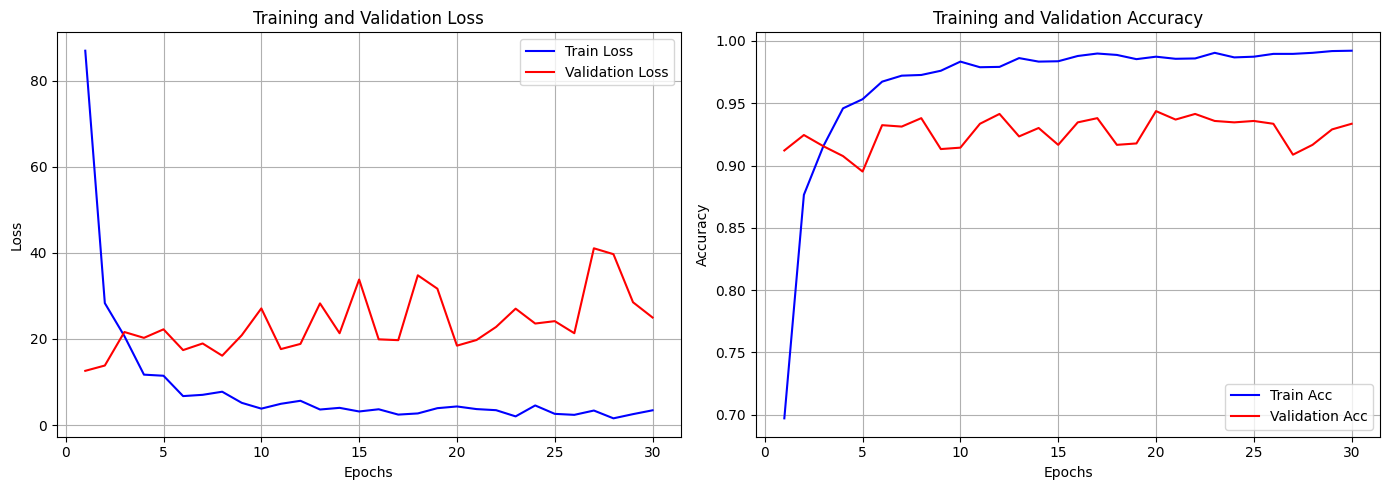

In [ ]:
epochs = range(1, len(history['train_loss']) + 1)


# 그래프 그리기 시작
plt.figure(figsize=(14, 5))


# 1. Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


# 2. Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_acc'], 'b-', label='Train Acc')
plt.plot(epochs, history['val_acc'], 'r-', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()
